

### 1. Build a model predicting infiltration with only those clusters changed by STK status.

In [3]:
import pickle

with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

In [68]:
# Regression against mutation status of driver genes and clusters
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv")
mOI = mutations[["Sample.ID"] + list(mutations.columns)[45:54] + list(mutations.columns)[61:64]]
y = mOI[~mOI["Sample.ID"].str.contains("IR")]

X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers = pd.DataFrame(model.transform())
centers.columns = np.arange(model.ncl) + 1
centers["Patient_ID"] = X.columns[4:]

# Reshape data (Patients vs NAT and tumor sample per cluster)
centers = find_patients_with_NATandTumor(centers.copy(), "Patient_ID", conc=True)
y = find_patients_with_NATandTumor(y.copy(), "Sample.ID", conc=False)
assert all(centers.index.values == y.index.values), "Samples don't match"

In [69]:
# Normalize
centers = centers.T
centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
centers = centers.T

In [76]:
s = "MASSKLREPVDEVFDLDLAVPETARLDSSLHKARAQLLAKGRRHRPSRSRLRDSASSAEDGEGSDGPGGKVTDGCGSPLHRLRSPLHSGPGSPAGGSFCLDPPGLRRSLDEDEPPPSPLTRYRPLHNAASHEGLAAASCSPPRSAPSSDSSPSFVRRHPRAEPHSEDDSRDASPPEPASPTIGLDKKTRRKFLDLGVTLRRASTGKSRKEKGSNRLSMGSRESVEGSGRSGGSPFLPFSWFTDSGKGSASSGSTTSPTCSPKHEGFSPKKSASQESTLSDDSTPPSSSPKIPSGPWQEAKCSYPYHTLSQSSDEFLDEPLPPVHHWTSQQVGQWLQSLNLEQYAAEFAARQVDGPQLLQLDGSKLKSLGLSNSHDRALVKRKLKEMAAAAEKERKAQEKAARQREKLRRREQEAKKS"

In [70]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

centers["STK11"] = y["STK11.mutation.status"].values
pvals = calculate_mannW_pvals(centers, "STK11", 1, 0)
pvals = build_pval_matrix(model.ncl, pvals)
plot_clusters_binaryfeatures(centers, "STK11", ["WT", "Mutant"], ax[0], pvals=pvals)

ValueError: Length of values (48) does not match length of index (24)

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers = pd.DataFrame(model.transform())
centers.columns = np.arange(model.ncl) + 1
centers["Patient_ID"] = X.columns[4:]
centers = centers.loc[~centers["Patient_ID"].str.endswith(".N"), :].sort_values(by="Patient_ID").set_index("Patient_ID")

# Import Cold-Hot Tumor data
y = pd.read_csv("msresist/data/MS/CPTAC/Hot_Cold.csv").dropna(axis=1).sort_values(by="Sample ID")
y = y.loc[~y["Sample ID"].str.endswith(".N"), :].set_index("Sample ID")
l1 = list(centers.index)
l2 = list(y.index)
dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
centers = centers.drop(dif)

# Transform to binary
y = y.replace("Cold-tumor enriched", 0)
y = y.replace("Hot-tumor enriched", 1)
y = np.squeeze(y)

# Remove NAT-enriched samples
centers = centers.drop(y[y == "NAT enriched"].index)
y = y.drop(y[y == "NAT enriched"].index).astype(int)
assert all(centers.index.values == y.index.values), "Samples don't match"

In [45]:
centers.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,
C3L.00001,0.594550,0.648802,0.084289,0.166812,0.637569,0.630314,-0.854876,0.882845,0.533298,0.764696,-1.058764,0.418024,0.287558,0.929498,0.678741,0.434189,0.393620,0.295551,-0.108088,0.445750,0.532753,-0.028243,-0.412152,0.532662
C3L.00009,0.404023,0.502797,0.242479,0.456661,0.272150,0.436679,-0.025170,0.704287,0.224375,0.437396,-0.448317,0.161508,-0.186802,0.572492,0.247537,0.526339,0.269335,0.196286,0.089981,0.242574,-0.068322,0.188478,-0.309845,0.148611
C3L.00080,1.086566,1.002628,0.197270,1.343795,0.992866,0.942843,1.326641,0.939884,0.727183,1.082913,-0.354019,0.919639,0.375704,1.076036,1.126133,0.812222,0.627318,0.407507,-0.037514,0.664594,0.597631,0.683023,-0.172398,0.850558
C3L.00083,-0.817188,-1.010016,-0.194024,-0.025924,-0.422903,-0.751848,-0.561069,-0.074996,-0.545353,-0.767604,-0.851259,-0.425803,-1.024443,-0.911448,-0.468442,-1.192603,-0.170958,-0.445978,-0.599277,-0.287035,-0.869840,-0.967266,-0.901126,-0.198685
C3L.00093,0.680801,0.703156,0.200945,0.958308,0.481742,0.661098,-0.176391,0.564009,0.428672,0.733521,-0.915627,0.279687,0.180849,0.659223,0.506740,0.640439,0.431334,0.309774,-0.070010,0.437491,0.210187,0.320741,-0.263474,0.373266


In [46]:
from msresist.figures.figureM4 import find_patients_with_NATandTumor

X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers = pd.DataFrame(model.transform())
centers.columns = np.arange(model.ncl) + 1
centers["Patient_ID"] = X.columns[4:]


# Regression against mutation status of driver genes and clusters
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv")
mOI = mutations[["Sample.ID"] + list(mutations.columns)[45:54] + list(mutations.columns)[61:64]]
y = mOI[~mOI["Sample.ID"].str.contains("IR")]

centersT = find_patients_with_NATandTumor(centers.copy(), "Patient_ID", conc=True)
yT = find_patients_with_NATandTumor(y.copy(), "Sample.ID", conc=False)
assert all(centersT.index.values == yT.index.values), "Samples don't match"

# Normalize
# centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
# centers = centers.T

In [47]:
centers

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Patient_ID
0,0.294747,0.351844,0.207985,0.618332,0.708809,0.599267,-0.215257,0.643430,0.415923,0.587878,-0.532391,0.058138,0.024398,0.475805,0.674964,0.378343,0.394478,0.281499,-0.040787,0.446284,0.064886,-0.242939,-0.177513,0.457148,C3N.01799
1,-1.614558,-1.325078,-0.050806,-0.775810,-1.010525,-0.666592,-0.205011,-0.636184,-0.748818,-1.134512,0.483200,-2.276423,-0.575380,-0.755059,-1.347966,-0.437278,-0.696795,-0.314107,0.164274,-0.698803,-0.901979,-1.788853,0.159142,-1.174833,C3N.01799.N
2,-0.219628,-0.630868,-0.444135,-0.319895,-0.352022,-0.808950,0.222777,-0.661228,-0.317550,-0.520279,-1.104695,0.047989,-0.507110,-0.831509,-0.238684,-1.424797,-0.343109,-0.602791,-0.978377,-0.377102,-0.117359,-0.282762,-0.904703,-0.050723,C3L.01890
3,-1.020283,-1.035466,0.415967,-0.315716,-0.741503,-0.644547,-0.194239,0.067924,-0.423939,-0.917951,0.285490,-1.275675,-0.306996,-0.632184,-0.945572,-0.738598,-0.287980,-0.148301,0.167208,-0.322263,-0.293526,-1.049033,-0.014552,-0.555225,C3L.01890.N
4,-0.054376,0.055562,0.008908,0.367575,0.046618,0.055221,-0.307042,0.219188,0.174997,0.116025,-0.370646,-0.344396,0.429969,0.061211,0.034937,-0.124106,-0.024690,0.043443,-0.129437,0.080679,0.381891,-0.486832,0.264333,0.022511,C3N.00572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,-1.187711,-0.921590,-0.206948,-0.141198,-0.620725,-0.215307,0.065199,-1.268884,-0.358554,-0.760121,0.080332,-1.764928,0.153916,-0.424604,-0.931493,0.068198,-0.225299,0.092292,0.335985,-0.264681,-0.435614,-1.203823,0.534088,-0.719130,C3N.01823.N
211,-0.142611,0.307012,0.171754,0.253827,0.332586,0.170203,1.006407,0.301664,0.394651,0.237409,-0.013669,-0.111582,0.371258,-0.192640,0.240328,-0.056661,0.448623,0.285870,-0.106340,0.409108,0.240532,0.153609,-0.065361,0.481197,C3L.02549
212,-1.237585,-0.940874,-0.366166,-0.743644,-0.602810,-0.226368,-0.088148,-1.543468,-0.374598,-0.698406,0.186884,-1.876870,-0.083512,-0.487072,-0.944532,0.127461,-0.351713,0.034522,0.360792,-0.351723,-0.617655,-1.401242,0.324926,-0.807107,C3L.02549.N
213,0.741284,0.699556,0.143997,0.005655,0.707168,0.699689,-0.783690,0.639547,0.615739,0.855645,-0.560239,0.562037,0.668226,0.788773,0.836810,0.615621,0.372317,0.296917,-0.053707,0.502904,0.609927,-0.044414,-0.081156,0.620135,C3L.02365


In [26]:
# coi = [1, 3, 5, 6, 11, 12, 14, 15, 16, 18, 19, 21, 22, 23, 24]
# centers = centers.loc[:, coi]

# Normalize
centers = centers.T
centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
centers = centers.T

In [49]:
from msresist.figures.figureM3 import build_pval_matrix, calculate_mannW_pvals, plot_clusters_binaryfeatures

# centers["HCT"] = y.values
# pvals = calculate_mannW_pvals(centers, "HCT", 1, 0)
# pvals = build_pval_matrix(model.ncl, pvals)

In [28]:
pvals

,Clusters,p-value,Significant
0,1,0.148858,Not Significant
1,2,0.148858,Not Significant
2,3,0.314838,Not Significant
3,4,0.732684,Not Significant
4,5,0.630398,Not Significant
5,6,0.263298,Not Significant
6,7,0.761652,Not Significant
7,8,0.136874,Not Significant
8,9,0.630398,Not Significant
9,10,0.673522,Not Significant


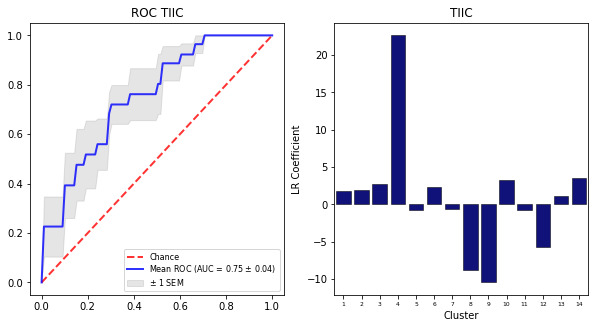

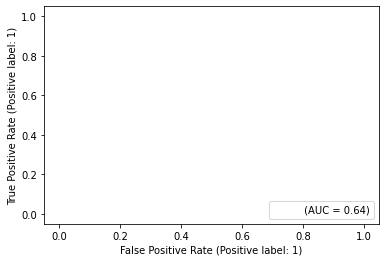

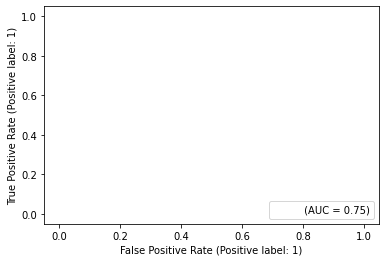

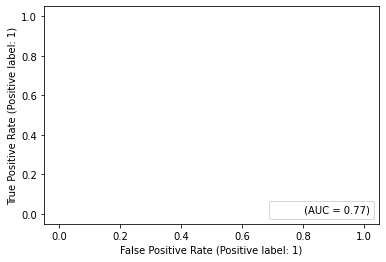

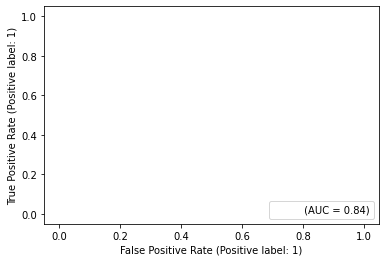

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from msresist.logistic_regression import plotROC, plotClusterCoefficients
import matplotlib.pyplot as plt

lr = LogisticRegressionCV(cv=7, solver="saga", max_iter=100000, n_jobs=-1, penalty="elasticnet", class_weight="balanced", l1_ratios=[0.1, 0.9])

_, ax = plt.subplots(1, 2, figsize=(10, 5))


plotROC(ax[0], lr, centers.iloc[:, :-1].values, y, cv_folds=4, title="ROC TIIC")
plotClusterCoefficients(ax[1], lr.fit(centers.iloc[:, :-1], y.values), title="TIIC")

### 2. Build a model that predicts STK, build a model that predicts infiltration, and look for shared cluster dependencies.

Clusters 18 and 21 (figures 4A and 5A)